In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange
import multiprocessing as mp
import timeit

olefile module not found


In [2]:
ncore = mp.cpu_count()
ncore

48

In [3]:
# need to change
ipts="26647"
# scan_type = 'ct_scans'
scan_type = 'radiographs'

In [4]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
os.listdir(scan_loc)

['2023_06_16_far_near_redo',
 '2023_06_14_pores_in_polymer',
 '2023_06_12_Cu_foils',
 '2022_04_27_electrodes_Nelson',
 '2022_05_04_samples2',
 '2021_05_29_OB_stepping',
 '2023_05_28_Zr4',
 '2022_05_02_Ti64_AM_DOE',
 '2023_05_30_battery_disks_redo',
 '2022_04_28_Monolisa_angles',
 '2022_04_22_Monalisa_G0',
 '2023_05_26_salt',
 '2023_05_26_battery2',
 '2023_06_12_highres_nGI',
 '2022_04_23_Monalisa_G1_loop_backlash_400nm',
 '2022_04_15_stability',
 '2023_05_30_battery_disks',
 '2022_05_03_stability_pump',
 '2023_05_25_monalisa_DOE',
 '2022_04_26_Ti64_stepping',
 '2023_06_14_graphite_thin_redo1',
 '2023_06_15_weld',
 '2022_04_23_Monalisa_G1_loop_backlash',
 '2022_04_23_Monalisa_G1_loop',
 '2022_04_29_metals',
 '2023_05_26_battery1',
 '2023_06_14_graphite_thin_redo',
 '2022_04_26_quartz',
 '2023_06_12_gratings_exam_high_res',
 '2023_06_14_AMed_samples',
 '2022_04_16_stability_brick_on',
 '2022_05_03_samples',
 '2023_05_26_monalisa_DOE_small',
 '2022_04_25_Monalisa_G1_400nm_16mm',
 '2022_04

In [11]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2021_05_DOE_block_CT_step09',
 '2021_05_30_CT_step01',
 '2021_05_DOE_block_CT_step05',
 '2021_05_DOE_block_CT_step01',
 '2021_05_DOE_block_CT_step06',
 '2021_05_DOE_block_CT_step02',
 '2021_05_DOE_block_CT_step11',
 '2021_05_30_CT_step02',
 '2021_05_DOE_block_CT_step03',
 '2021_05_DOE_block_CT_step10',
 '2022_04_22_G0_out',
 '2021_05_29_CT_step01',
 '2021_05_DOE_block_CT_step07',
 '2022_04_24_stability',
 '2023_06_12_highres',
 '2023_06_16_far_near',
 '2021_05_DOE_block_CT_step08',
 '2021_05_29_CT_step02',
 '2021_05_DOE_block_CT_step04']

In [6]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
os.listdir(dc_loc)

['2023_05_24', '2023_06_09_high_res']

In [12]:
###################### need to change start
sample_name = "2023_06_16_far_near_redo"
scan_dir = os.path.join(scan_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2023_06_16_far_near")
dc_dir = os.path.join(dc_loc, "2023_05_24")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
gamma_diff = 20
###################### need to change end

# Preprocess CT scan files

In [13]:
fname_list = os.listdir(scan_dir)
# fname_list.pop(0)
fname_list.sort()
fname_list

['20230616_film_135mm_away_0020_0052.tiff',
 '20230616_film_135mm_away_0020_0053.tiff',
 '20230616_film_135mm_away_0020_0054.tiff',
 '20230616_film_15mm_away_0020_0046.tiff',
 '20230616_film_15mm_away_0020_0047.tiff',
 '20230616_film_15mm_away_0020_0048.tiff',
 '20230616_film_175mm_away_0020_0055.tiff',
 '20230616_film_175mm_away_0020_0056.tiff',
 '20230616_film_175mm_away_0020_0057.tiff',
 '20230616_film_210mm_away_0020_0058.tiff',
 '20230616_film_210mm_away_0020_0059.tiff',
 '20230616_film_210mm_away_0020_0060.tiff',
 '20230616_film_55mm_away_0020_0043.tiff',
 '20230616_film_55mm_away_0020_0044.tiff',
 '20230616_film_55mm_away_0020_0045.tiff',
 '20230616_film_95mm_away_0020_0049.tiff',
 '20230616_film_95mm_away_0020_0050.tiff',
 '20230616_film_95mm_away_0020_0051.tiff',
 '20230616_weld_015mm_away_0020_0076.tiff',
 '20230616_weld_015mm_away_0020_0077.tiff',
 '20230616_weld_015mm_away_0020_0078.tiff',
 '20230616_weld_055mm_away_0020_0073.tiff',
 '20230616_weld_055mm_away_0020_0074.tiff

In [16]:
ob_list = os.listdir(ob_dir)
# fname_list.pop(0)
ob_list.sort()
ob_list = ob_list[:3]
ob_list

['20230616_OB_0020_0040.tiff',
 '20230616_OB_0020_0041.tiff',
 '20230616_OB_0020_0042.tiff']

In [17]:
dc_list = os.listdir(dc_dir)
# fname_list.pop(0)
dc_list.sort()
dc_list

['20230524_DC_0030_0001.tiff',
 '20230524_DC_0030_0002.tiff',
 '20230524_DC_0030_0003.tiff',
 '20230524_DC_0030_0004.tiff',
 '20230524_DC_0030_0005.tiff']

In [18]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)
print(scan_raw.shape)
######### OB
ob_raw = rocku.read_tiff_stack(ob_dir, ob_list)
print(ob_raw.shape)
######### DC
dc_raw = rocku.read_tiff_stack(dc_dir, dc_list)
print(dc_raw.shape)

36it [00:03, 11.93it/s]


(36, 2048, 2048)


3it [00:00, 18.41it/s]


(3, 2048, 2048)


5it [00:00, 14.91it/s]

(5, 2048, 2048)


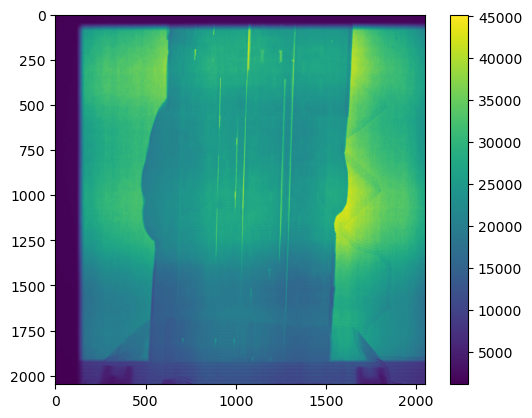

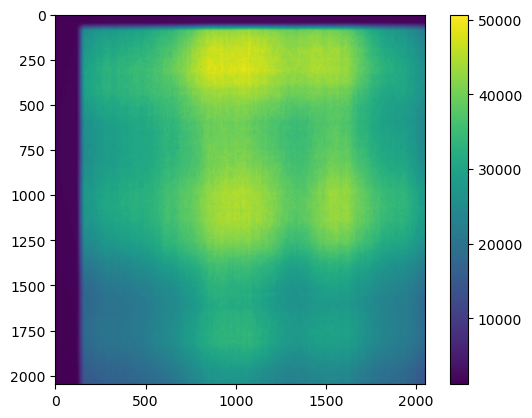

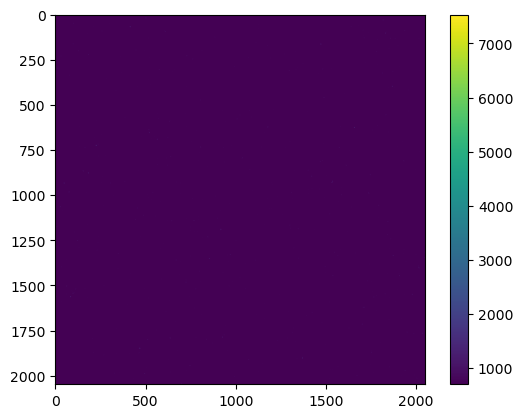

In [19]:
scan_min = np.min(scan_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(scan_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Crop ROI

Recon ROI:


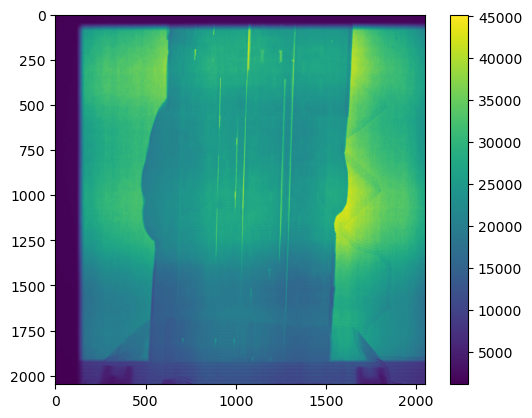

In [20]:
###################### need to change start
crop = False
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 500
crop_right = 6000
crop_top = 1500
crop_bottom = 5000
###################### need to change end
scan_crop = rocku.crop(scan_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
scan_crop_min = rocku.crop(scan_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(scan_crop_min)
plt.colorbar()
plt.show()

# Removal outliers

In [21]:
t0 = timeit.default_timer()
scan_crop = tomopy.misc.corr.remove_outlier(scan_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Time: 4.106972580077127 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(36, 2048, 2048)


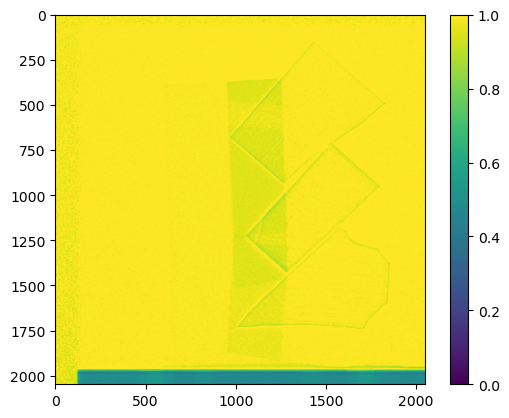

In [22]:
scan_norm, ob_med, dc_med = rocku.normalize(scan_crop, ob_crop, dc_crop)
print(scan_norm.dtype)
print(scan_norm.shape)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)


In [ ]:
###################### need to change start
bg_left = 2450
bg_right = 2850
bg_top = 500
bg_bottom = 3000
###################### need to change end
bg_stack = scan_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
t0 = timeit.default_timer()
scan_norm = tomopy.prep.normalize.normalize_roi(scan_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

# Save files

In [23]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/normalized/" + sample_name
for i, e_name in enumerate(fname_list):
#     e_name = rocku.remove_1st_str(e_name)
    fname = save_to + "/" + e_name
    print('Saving to {} ...'.format(fname))
    dxchange.write_tiff(scan_norm[i], fname=fname, overwrite=True)
# dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)
# print('Combining with median ...')
# scan_med = np.median(scan_norm, axis=0)
# print(scan_med.dtype)
# dxchange.write_tiff(scan_med, fname=save_to + "/MED", overwrite=True)
# dxchange.write_tiff(ob_med, fname=save_to + "/OB_DC", overwrite=True)
# dxchange.write_tiff(dc_med, fname=save_to + "/DC", overwrite=True)

Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_135mm_away_0020_0052.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_135mm_away_0020_0053.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_135mm_away_0020_0054.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_15mm_away_0020_0046.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_15mm_away_0020_0047.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_15mm_away_0020_0048.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/2023_06_16_far_near_redo/20230616_film_175mm_away_0020_0055.tiff ...
Saving to /HFIR/CG1D/IPTS-26647/shared/processed_data/normalized/